In [1]:
import re
import pandas as pd
import numpy as np
import h5py
import torch
from torch.utils.data import Dataset
from scipy.signal import butter, filtfilt, resample
from typing import Tuple
import matplotlib.pyplot as plt


from BedrettoDataset import BedrettoDataset
from phasenet import PhaseNet

In [2]:
dataset = BedrettoDataset(csv_file='..\\data\\train\\metadata.csv', h5_file='..\\data\\train\\waveforms.hdf5', width=5864)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

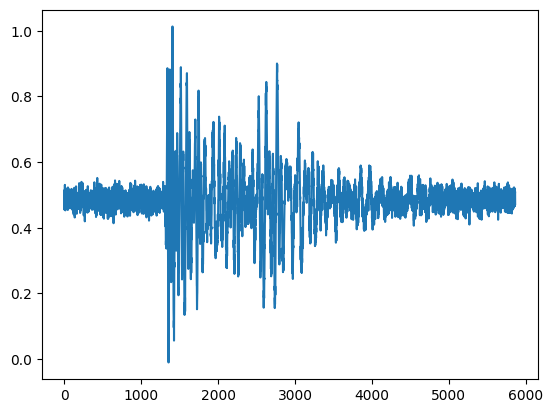

In [3]:
plt.plot(next(iter(train_loader))[0][0][0].detach().numpy())

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
    
model = PhaseNet().to(device)

epochs = 5
learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

In [5]:
from phasenet import PhaseNet

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs, logits=True)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.cpu().detach().numpy() / inputs.shape[0]
        if (not i%10):
            print(f"Iteration {i}/{len(train_loader)}, Loss: {train_loss / (i+1)}")  # print mean training loss so far
            
    print(f"End of Epoch mean training loss {train_loss / len(train_loader)}")
            
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs, logits=True)
            val_loss += criterion(outputs, labels) / inputs.shape[0]
        
        print(f'Validation loss for epoch {epoch+1}: ', val_loss / len(val_loader))

Iteration 0/110, Loss: 0.03732305392622948
Iteration 10/110, Loss: 0.0350211967121471
Iteration 20/110, Loss: 0.0333900981183563
Iteration 30/110, Loss: 0.03203535368365626
Iteration 40/110, Loss: 0.030812747912799438
Iteration 50/110, Loss: 0.029693403080397963
Iteration 60/110, Loss: 0.028642565561611145
Iteration 70/110, Loss: 0.027641760316533103
Iteration 80/110, Loss: 0.026692092349683796
Iteration 90/110, Loss: 0.02578617534139654
Iteration 100/110, Loss: 0.02492132325573723
End of Epoch mean training loss 0.024254735025831243
Validation loss for epoch 1:  tensor(0.0159)
Iteration 0/110, Loss: 0.015098834410309792
Iteration 10/110, Loss: 0.01448537324639884
Iteration 20/110, Loss: 0.013919686144661336
Iteration 30/110, Loss: 0.0133844597205039
Iteration 40/110, Loss: 0.012876566090598339
Iteration 50/110, Loss: 0.012398332722631156


C:\Users\tolga\AppData\Local\Temp\ipykernel_14424\480676827.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = torch.nn.functional.softmax(model.forward(inputs, logits=True))


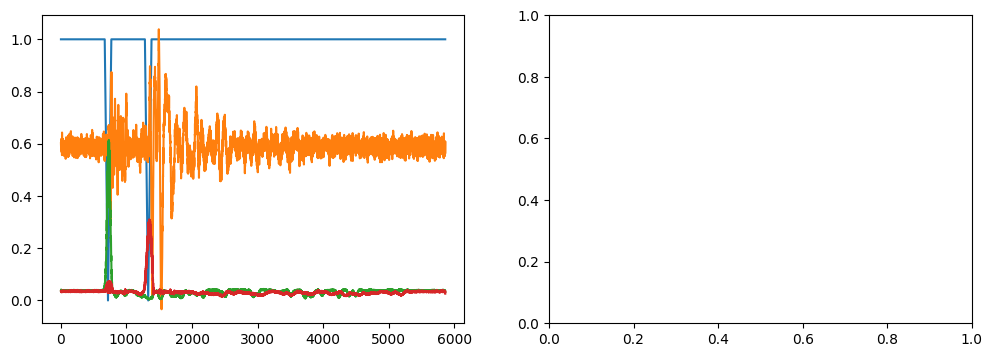

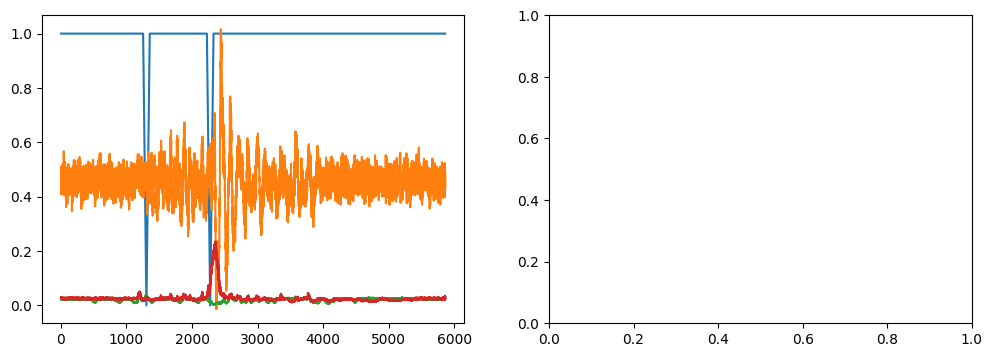

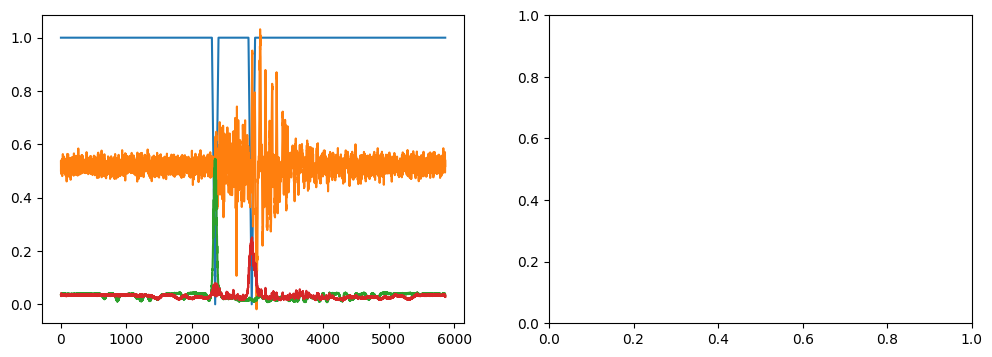

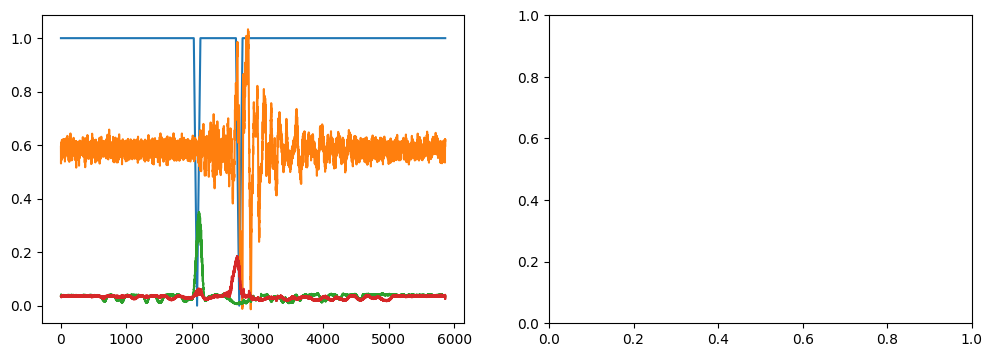

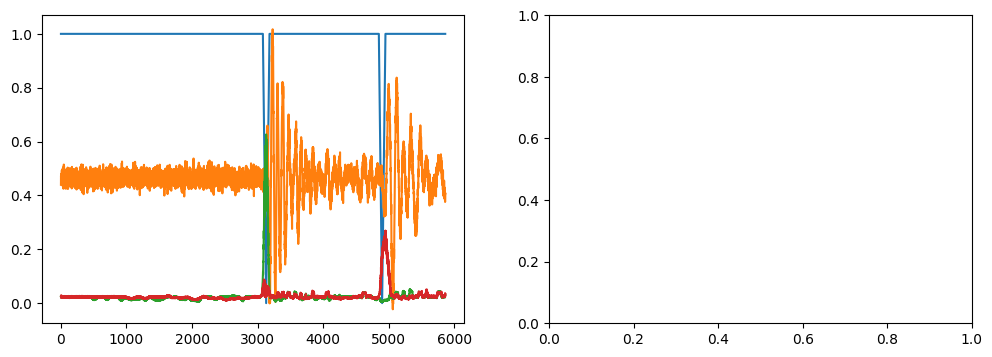

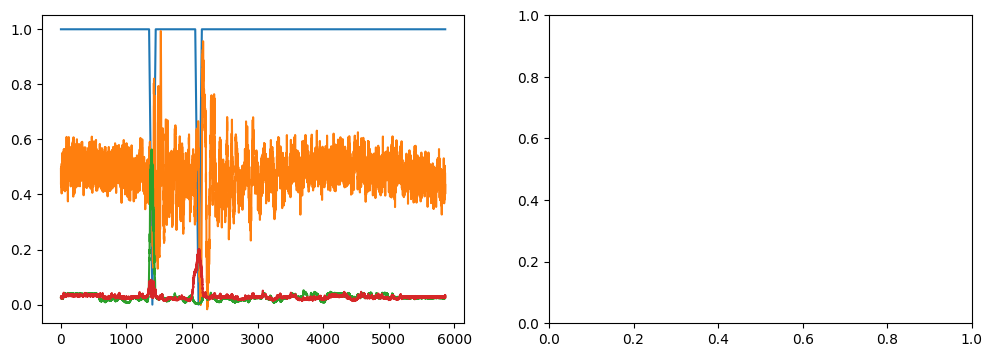

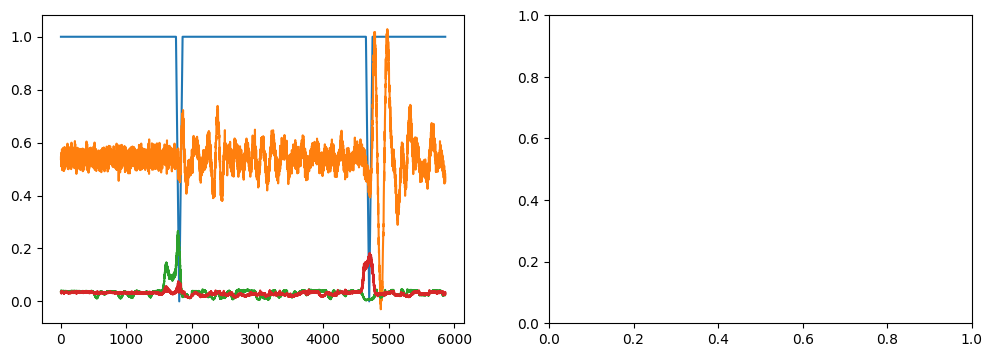

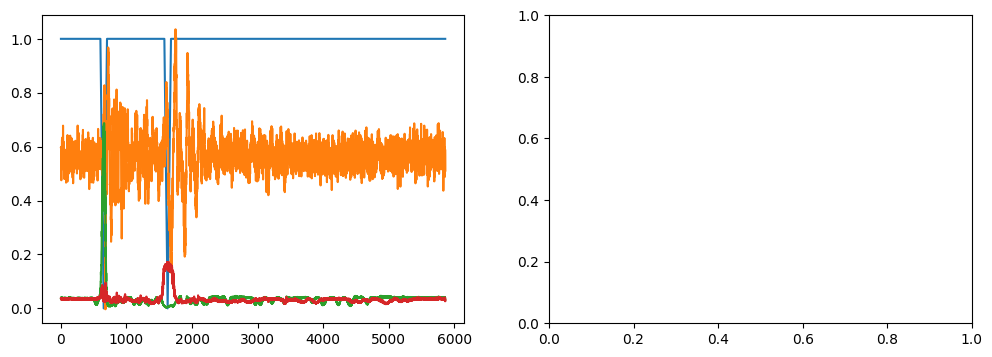

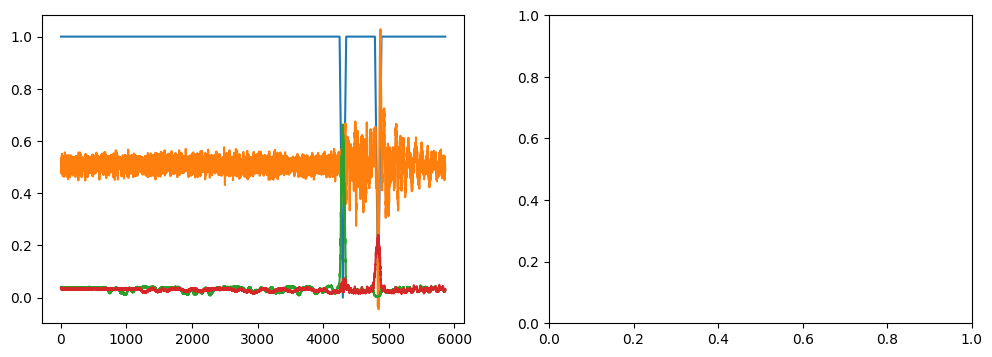

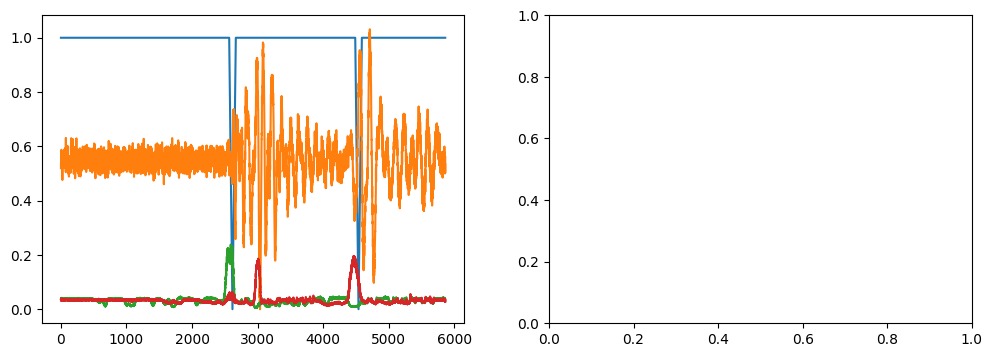

In [18]:
import seisbench.models as sbm 
import sys 
sys.path.append("..")
from models.PhaseNet import PhaseNet
pnet_pretrained = sbm.PhaseNet.from_pretrained('original')
# Assuming pnet_pretrained is your pretrained model and inc is the first Conv1d layer

# Get the weights from the first channel of the pretrained layer
weights = pnet_pretrained.inc.weight.data[:, 0:1, :]

# Create a new Conv1d layer with a single input channel
new_layer = torch.nn.Conv1d(1, pnet_pretrained.inc.out_channels, pnet_pretrained.inc.kernel_size[0])

# Set the weights of the new layer
new_layer.weight.data = weights

# Replace the first Conv1d layer in the pretrained model with the new layer
pnet_pretrained.inc = new_layer

# our own model trained on STEAD
pnet_stead = torch.load("..\\classification_tolga\\phasenet_15epochs.pt")


batch_num = 2
with torch.no_grad():
    for i, (inputs, labels) in enumerate(val_loader):
        if (i > 0):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = torch.nn.functional.softmax(model.forward(inputs, logits=True))

            fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # Create 2 subplots

            # Plot on the first subplot
            axs[0].plot(labels.cpu().detach().numpy()[i, 2])
            axs[0].plot(inputs.cpu().detach().numpy()[i, 0])
            axs[0].plot(outputs.cpu().detach().numpy()[i,0,:])
            axs[0].plot(outputs.cpu().detach().numpy()[i,1,:])

            plt.show()
            if (i == 10): break